The implementation of CV is in `sequences Exploration.ipynb`

Check

The following uses XGBoost + target encoder all census features
1. Fixed + Distance >> 0.63    vs .53
2. Fixed >> 0.51    vs  .39
3. Distance  >> 0.62    vs .48
4. No sequence >>  0.49  vs .35
5. dwelling >> 0.51. vs .39
6. dwelling + distance >> 0.65  vs  .53   +++++**BEST wo CV**+++++
7. dwelling + distance ** with ordinal encoded `CENSUS_dwelling_num` >> 0.63   vs 0.60  ++++**BEST with CV**++++
8. dwelling + distance ** with target encoded `CENSUS_dwelling_num` >> 0.60. vs .47  

**Conclusion::: dwelling + distance + (all target encoded) + not include `CENSUS_dwelling_num` is best**



====== include enumerator data ======
9. dwelling + distance + \[enu_num + enu_date + ancestry_ref\]  >> 0.64  vs 0.54
10. \[enu_num + enu_date + ancestry_ref\]  >> 0.50   vs. 0.40
11. enu seq >> 0.49  vs. 0.41
12. dwelling + distance + enu seq >> 0.62    vs. 52
13. enum_dist seq + dwelling + distance + fixed >> 0.67   vs  .53 +++++ **BEST** +++++
14. enum_dist seq only >> 0.66  vs  .58  +++++ **BEST w CV** +++++



**Conclusion:: a bit improvement when include enum_dist sequence**

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from interpolation import CensusData, sequences, BlockInterpolator, \
                        CentroidInterpolator, archive, interpolation
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [2]:
#Change these values to rerun the notebook
filled_1850 = pd.read_csv("../../data/dwelling_filled_sum_1850_mn_v01.csv")
cd_1850 = pd.read_csv("../../data/cd_1850_XYupdate.csv") #For calculating centroids
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"Ward_Num", "CENSUS_SERIALP":"CENSUS_SERIALB", 
                              "BLOCK_NUM":"block_num", "CENSUS_REEL_HOUSEHOLD":"CENSUS_REEL", 
                              "CENSUS_SEX":"CENSUS_SEXB", "CENSUS_PAGENO_HOUSEHOLD":"CENSUS_PAGENUM", 
                              "CENSUS_RACE":"CENSUS_RACEB", "CD_X":"cd_X", "CD_Y":"cd_Y"}, inplace = True)
ward_col = "Ward_Num"
dwelling_col = "dwelling_id"
dwelling_col_num = "CENSUS_DWELLING_NUM"
block_col = "block_num"
x_col = "cd_X"
y_col = "cd_Y"
pagenum = "CENSUS_PAGENNO"

In [3]:
filled_1850.head(2)

,block_num,CD_ADDRESS,cd_X,cd_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_NUM,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,CENSUS_GEOG,...,CENSUS_PLACE,CENSUS_RACEB,CENSUS_REEL,CENSUS_SEQ_NUM,CENSUS_SERIALB,CENSUS_SEXB,Ward_Num,dwelling_id,spatial_weight,spatial_weight_sum
0,3794.0,37 South,-74.00825,40.703128,49,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,MANHATTAN,120,534,1,2044262,1,1,1,NaN,NaN
1,3794.0,37 South,-74.00825,40.703128,36,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,MANHATTAN,120,534,2,2044263,2,1,1,NaN,NaN


In [4]:
cd_1850.head(2)

,OBJECTID,Join_Count,TARGET_FID,Join_Cou_1,TARGET_F_1,id,type,name,F__data_pa,F__data_te,...,cd_full__1,cd_full_re,cd_occupat,cd_addr,street_add,street_nam,Ward_Num,block_num,cd_X,cd_Y
0,1,1,1,1,1,1850-1851.169.63-215-566-246,st:Person,Evans Francis,169,"Evans Francis, painter, 130 Av. C",...,Francis Evans,"Evans Francis, painter, 130 Av. C",painter,130 Av . C,130 Avenue C,Avenue C,11.0,310,-73.978096,40.724956
1,2,1,2,1,2,1850-1851.169.63-342-684-374,st:Person,Evans George,169,"Evans George, pilot, 116 Wall, h. 9 Dover",...,George Evans,"Evans George, pilot, 116 Wall, h. 9 Dover",pilot,116 Wall,9 Dover Street,Dover Street,4.0,29,-74.000970,40.709062


In [5]:
#set clustering algo -- this is to make sure that the same clustering algorithm is used
#for each model, to ensure that testing is accurate
#note fitting before hand won't work for all types of clustering, for example, with agglomerative
#clustering this isn't going to work because the algorithm doesn't have a predict method
block_centroids = {ward:{block:interpolation.make_centroid(df_block[x_col], df_block[y_col]) for block, df_block in df.groupby(block_col)} for ward,df in cd_1850.groupby(ward_col)}

# Fixed + Distance

In [6]:
census_data = CensusData(filled_1850, ward_col=ward_col, dwelling_col=dwelling_col, 
                         block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_data.apply_sequencing(fixed = True, distance = True)

In [7]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", 
            "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL", 
            "CENSUS_ID", "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "fixed_seq"]
block_boost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", 
                                                             "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", 
                                                             "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", 
                                                             "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", 
                                                             "CENSUS_NAMEFRST", "CENSUS_NAMELAST", 
                                                             "CENSUS_OCCSTR", "CENSUS_IMPREL", "CENSUS_ID", 
                                                             "sequence_order_enum", 'CENSUS_DWELLING_SEQ', 
                                                             "fixed_seq"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

In [8]:
interpolate_sequences = CentroidInterpolator(census_data, 10, block_boost, all_cols, KMeans(5), block_centroids)

In [9]:
score, model = interpolate_sequences.kmeans_best(5)
interpolate_sequences.set_clustering_algo(model)
interpolate_sequences.apply_clustering(algo_fit = True)
# interpolate_sequences.clustervis(kmeans = True)

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


In [10]:
train,test = interpolate_sequences.stratified_train_test()
interpolate_sequences.train_test_model(train, test)

print("Training score:",interpolate_sequences.train_score)
print("Test score:", interpolate_sequences.test_score)

Training score: 1.0
Test score: 0.636523266022827


In [11]:
census_data.data.columns

Index(['block_num', 'CD_ADDRESS', 'cd_X', 'cd_Y', 'CENSUS_AGE', 'CENSUS_CITY',
       'CENSUS_DWELLING_NUM', 'CENSUS_DWELLING_SEQ', 'CENSUS_DWELLING_SIZE',
       'CENSUS_GEOG', 'CENSUS_HH_NUM', 'CENSUS_ID', 'CENSUS_IMPREL',
       'CENSUS_INDEX', 'CENSUS_IPUMS_UID', 'CENSUS_LABFORCE', 'CENSUS_LINE',
       'CENSUS_MARST', 'CENSUS_NAMEFRST', 'CENSUS_NAMELAST', 'CENSUS_OCCSTR',
       'CENSUS_PAGENUM', 'CENSUS_PLACE', 'CENSUS_RACEB', 'CENSUS_REEL',
       'CENSUS_SEQ_NUM', 'CENSUS_SERIALB', 'CENSUS_SEXB', 'Ward_Num',
       'dwelling_id', 'spatial_weight', 'spatial_weight_sum'],
      dtype='object')

In [12]:
## fixed + distance
census_data.df.columns

Index(['block_num', 'CD_ADDRESS', 'cd_X', 'cd_Y', 'CENSUS_AGE', 'CENSUS_CITY',
       'CENSUS_DWELLING_NUM', 'CENSUS_DWELLING_SEQ', 'CENSUS_DWELLING_SIZE',
       'CENSUS_GEOG', 'CENSUS_HH_NUM', 'CENSUS_ID', 'CENSUS_IMPREL',
       'CENSUS_INDEX', 'CENSUS_IPUMS_UID', 'CENSUS_LABFORCE', 'CENSUS_LINE',
       'CENSUS_MARST', 'CENSUS_NAMEFRST', 'CENSUS_NAMELAST', 'CENSUS_OCCSTR',
       'CENSUS_PAGENUM', 'CENSUS_PLACE', 'CENSUS_RACEB', 'CENSUS_REEL',
       'CENSUS_SEQ_NUM', 'CENSUS_SERIALB', 'CENSUS_SEXB', 'Ward_Num',
       'dwelling_id', 'spatial_weight', 'spatial_weight_sum', 'sequence_id',
       'num_between', 'sequence_order_enum', 'dist', 'sequence_len',
       'fixed_seq'],
      dtype='object')

# Fixed

In [13]:
census_data.apply_sequencing(fixed = True)
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", 
            "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL", 
            'CENSUS_DWELLING_SEQ', "fixed_seq"]
block_boost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "fixed_seq"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])
interpolate_fixed = CentroidInterpolator(census_data, 10, block_boost, all_cols, KMeans(5), block_centroids)

In [14]:
score, model = interpolate_fixed.kmeans_best(5)
interpolate_fixed.set_clustering_algo(model)
interpolate_fixed.apply_clustering(algo_fit = True)

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


In [15]:
train,test = interpolate_fixed.stratified_train_test()
interpolate_fixed.train_test_model(train, test)

In [16]:
print("Training score:",interpolate_fixed.train_score)
print("Test score:", interpolate_fixed.test_score)

Training score: 1.0
Test score: 0.510586319218241


In [17]:
## fixed
census_data.df.shape

(515630, 33)

In [18]:
census_data.df.columns

Index(['block_num', 'CD_ADDRESS', 'cd_X', 'cd_Y', 'CENSUS_AGE', 'CENSUS_CITY',
       'CENSUS_DWELLING_NUM', 'CENSUS_DWELLING_SEQ', 'CENSUS_DWELLING_SIZE',
       'CENSUS_GEOG', 'CENSUS_HH_NUM', 'CENSUS_ID', 'CENSUS_IMPREL',
       'CENSUS_INDEX', 'CENSUS_IPUMS_UID', 'CENSUS_LABFORCE', 'CENSUS_LINE',
       'CENSUS_MARST', 'CENSUS_NAMEFRST', 'CENSUS_NAMELAST', 'CENSUS_OCCSTR',
       'CENSUS_PAGENUM', 'CENSUS_PLACE', 'CENSUS_RACEB', 'CENSUS_REEL',
       'CENSUS_SEQ_NUM', 'CENSUS_SERIALB', 'CENSUS_SEXB', 'Ward_Num',
       'dwelling_id', 'spatial_weight', 'spatial_weight_sum', 'fixed_seq'],
      dtype='object')

In [19]:
len(all_cols)

16

# Distance

In [20]:
## distance
census_data.apply_sequencing(distance = True)
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", 
            "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",
            "sequence_order_enum", 'CENSUS_DWELLING_SEQ']
block_boost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", 
                                                             "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", 
                                                             "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", 
                                                             "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", 
                                                             "CENSUS_NAMEFRST", "CENSUS_NAMELAST", 
                                                             "CENSUS_OCCSTR", "CENSUS_IMPREL",  
                                                             "sequence_order_enum", 'CENSUS_DWELLING_SEQ'])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

In [21]:
interpolate_distance = CentroidInterpolator(census_data, 10, block_boost, all_cols, KMeans(5), block_centroids)
score, model = interpolate_distance.kmeans_best(5)
interpolate_distance.set_clustering_algo(model)
interpolate_distance.apply_clustering(algo_fit = True)

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


In [22]:
train,test = interpolate_distance.stratified_train_test()
interpolate_distance.train_test_model(train, test)
print("Training score:",interpolate_distance.train_score)
print("Test score:", interpolate_distance.test_score)

Training score: 1.0
Test score: 0.6407599309153713


In [23]:
## distance
census_data.df.columns

Index(['block_num', 'CD_ADDRESS', 'cd_X', 'cd_Y', 'CENSUS_AGE', 'CENSUS_CITY',
       'CENSUS_DWELLING_NUM', 'CENSUS_DWELLING_SEQ', 'CENSUS_DWELLING_SIZE',
       'CENSUS_GEOG', 'CENSUS_HH_NUM', 'CENSUS_ID', 'CENSUS_IMPREL',
       'CENSUS_INDEX', 'CENSUS_IPUMS_UID', 'CENSUS_LABFORCE', 'CENSUS_LINE',
       'CENSUS_MARST', 'CENSUS_NAMEFRST', 'CENSUS_NAMELAST', 'CENSUS_OCCSTR',
       'CENSUS_PAGENUM', 'CENSUS_PLACE', 'CENSUS_RACEB', 'CENSUS_REEL',
       'CENSUS_SEQ_NUM', 'CENSUS_SERIALB', 'CENSUS_SEXB', 'Ward_Num',
       'dwelling_id', 'spatial_weight', 'spatial_weight_sum', 'sequence_id',
       'num_between', 'sequence_order_enum', 'dist', 'sequence_len'],
      dtype='object')

# No seq

In [24]:
census_data.no_seq()

all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", 
            "CENSUS_RACEB","CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", 
            "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", 
            "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ']
block_boost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", 
                                                             "CENSUS_SEXB", "CENSUS_RACEB", "CENSUS_DWELLING_SIZE",
                                                             "CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
                                                             "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", 
                                                             "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ'])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

In [25]:
interpolate_noseq = CentroidInterpolator(census_data, 10, block_boost, all_cols, KMeans(5), block_centroids)
score, model = interpolate_noseq.kmeans_best(5)
interpolate_noseq.set_clustering_algo(model)
interpolate_noseq.apply_clustering(algo_fit = True)

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


In [26]:
train,test = interpolate_noseq.stratified_train_test()
interpolate_noseq.train_test_model(train, test)
print("Training score:",interpolate_noseq.train_score)
print("Test score:", interpolate_noseq.test_score)

Training score: 1.0
Test score: 0.4921996879875195


In [27]:
## no seq
census_data.df.columns

Index(['block_num', 'CD_ADDRESS', 'cd_X', 'cd_Y', 'CENSUS_AGE', 'CENSUS_CITY',
       'CENSUS_DWELLING_NUM', 'CENSUS_DWELLING_SEQ', 'CENSUS_DWELLING_SIZE',
       'CENSUS_GEOG', 'CENSUS_HH_NUM', 'CENSUS_ID', 'CENSUS_IMPREL',
       'CENSUS_INDEX', 'CENSUS_IPUMS_UID', 'CENSUS_LABFORCE', 'CENSUS_LINE',
       'CENSUS_MARST', 'CENSUS_NAMEFRST', 'CENSUS_NAMELAST', 'CENSUS_OCCSTR',
       'CENSUS_PAGENUM', 'CENSUS_PLACE', 'CENSUS_RACEB', 'CENSUS_REEL',
       'CENSUS_SEQ_NUM', 'CENSUS_SERIALB', 'CENSUS_SEXB', 'Ward_Num',
       'dwelling_id', 'spatial_weight', 'spatial_weight_sum'],
      dtype='object')

# dwelling_col_num sequence id 

In [28]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", 
            "CENSUS_RACEB","CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", 
            "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", 
            "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "dwelling_seq_id"]
block_boost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", 
                                                             "CENSUS_SEXB", "CENSUS_RACEB", "CENSUS_DWELLING_SIZE",
                                                             "CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
                                                             "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST",
                                                             "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ',
                                                             "dwelling_seq_id"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

In [29]:
census_data.apply_sequencing(dwelling = True)
interpolate_dwell = CentroidInterpolator(census_data, 10, block_boost, all_cols, KMeans(5), block_centroids)
score, model = interpolate_dwell.kmeans_best(5)
interpolate_dwell.set_clustering_algo(model)
interpolate_dwell.apply_clustering(algo_fit = True)
# interpolate_dwell.clustervis(kmeans = True)

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


In [30]:
train,test = interpolate_dwell.stratified_train_test()
interpolate_dwell.train_test_model(train, test)
print("Training score:",interpolate_dwell.train_score)
print("Test score:", interpolate_dwell.test_score)

Training score: 1.0
Test score: 0.48947368421052634


# dwelling and distance

In [31]:
#I think dwelling num would need to be preprocessed
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB",
            "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", 
            "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', 
            "sequence_order_enum", "sequence_id", "dwelling_seq_id"]
block_boost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", 
                                                             "CENSUS_SEXB", "CENSUS_RACEB", "CENSUS_DWELLING_SIZE",
                                                             "CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
                                                             "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", 
                                                             "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ',
                                                             "sequence_order_enum", "sequence_id", "dwelling_seq_id"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

In [32]:
census_data.apply_sequencing(distance = True, dwelling = True)
interpolate_dwell_dist = CentroidInterpolator(census_data, 10, block_boost, all_cols, KMeans(5), block_centroids)
score, model = interpolate_dwell_dist.kmeans_best(5)
interpolate_dwell_dist.set_clustering_algo(model)
interpolate_dwell_dist.apply_clustering(algo_fit = True)
# interpolate_dwell_dist.clustervis(kmeans = True)

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


In [33]:
train,test = interpolate_dwell_dist.stratified_train_test()
interpolate_dwell_dist.train_test_model(train, test)
print("Training score:",interpolate_dwell_dist.train_score)
print("Test score:", interpolate_dwell_dist.test_score)

Training score: 1.0
Test score: 0.6545768566493955


# ** Include `CENSUS_dwelling_num`

Tabitha: `dwelling_col_num` should be processed

### Ordinal encoded `CENSUS_DWELLING_NUM` 

In [34]:
## take the first record of each ward_num and dwelling_id pair
dwellings_1850 = filled_1850.groupby([ward_col, dwelling_col], as_index = False).first()

In [35]:
#Ordinal encoding (leaving as numeric)
all_cols = ["CENSUS_DWELLING_NUM","CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", 
            "CENSUS_RACEB","CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",
            'CENSUS_DWELLING_SEQ', "sequence_order_enum", "sequence_id", "dwelling_seq_id"]
ordinal_encode = make_column_transformer((OrdinalEncoder(), ['CENSUS_DWELLING_NUM']))
block_boost_ord = Pipeline([('ordinal encode', ordinal_encode),
    ('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", 
                                         "CENSUS_RACEB", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", 
                                         "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", 
                                         "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ',
                                         "sequence_order_enum", "sequence_id", "dwelling_seq_id"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


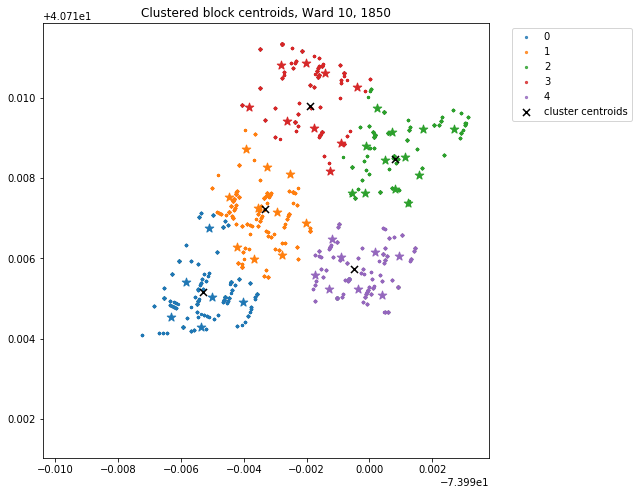

In [36]:
# census_data.no_seq()
census_data.apply_sequencing(distance = True, dwelling = True)
interpolate_dwell_ord = CentroidInterpolator(census_data, 10, block_boost, all_cols, KMeans(5), block_centroids)
score, model = interpolate_dwell_ord.kmeans_best(5)
interpolate_dwell_ord.set_clustering_algo(model)
interpolate_dwell_ord.apply_clustering(algo_fit = True)
interpolate_dwell_ord.clustervis(kmeans = True)

In [37]:
train,test = interpolate_dwell_ord.stratified_train_test()
interpolate_dwell_ord.train_test_model(train, test)
print("Training score:",interpolate_dwell_ord.train_score)
print("Test score:", interpolate_dwell_ord.test_score)

Training score: 1.0
Test score: 0.6096959737058341


### Target encoded `CENSUS_DWELLING_NUM` 

In [38]:
#target encoding
all_cols = ["CENSUS_DWELLING_NUM","CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", 
            "CENSUS_RACEB","CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",
            'CENSUS_DWELLING_SEQ', "sequence_order_enum", "sequence_id", "dwelling_seq_id"]
block_boost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_DWELLING_NUM","CENSUS_SERIALB", 
                                                             "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", 
                                                             "CENSUS_RACEB", "CENSUS_DWELLING_SIZE",
                                                             "CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
                                                             "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST",
                                                             "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ',
                                                             "sequence_order_enum", "sequence_id", 
                                                             "dwelling_seq_id"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

In [39]:
census_data.apply_sequencing(dwelling = True, distance = True)
interpolate_dwell_ord_enc = CentroidInterpolator(census_data, 10, block_boost, all_cols, KMeans(5), block_centroids)
score, model = interpolate_dwell_ord_enc.kmeans_best(5)
interpolate_dwell_ord_enc.set_clustering_algo(model)
interpolate_dwell_ord_enc.apply_clustering(algo_fit = True)
# interpolate_dwell_ord_enc.clustervis(kmeans = True)

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


In [40]:
train,test = interpolate_dwell_ord_enc.stratified_train_test()
interpolate_dwell_ord_enc.train_test_model(train, test)
print("Training score:",interpolate_dwell_ord_enc.train_score)
print("Test score:", interpolate_dwell_ord_enc.test_score)

Training score: 1.0
Test score: 0.5695897023330652


# Include enumeration date

In [41]:
enumerators = pd.read_csv("../../data/census_1850_enumerationDetail_mn_ward10.csv")

In [42]:
enumerators.head()

,CENSUS_PAGENO_HOUSEHOLD,CENSUS_PAGENNO,CENSUS_WARD_NUM,CENSUS_REEL_HOUSEHOLD,CENSUS_ENUMERATOR_NUM,CENSUS_ENUMERATOR_DATE,ANCESTRY_REF
0,60,6,10,545,1,1850-07-15,4202063_6
1,70,7,10,545,1,1850-07-15,4202063_7
2,80,8,10,545,1,1850-07-15,4202063_8
3,90,9,10,545,1,1850-07-15,4202063_9
4,100,10,10,545,1,1850-07-15,4202063_10


In [44]:
enumerators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 7 columns):
CENSUS_PAGENO_HOUSEHOLD    553 non-null int64
CENSUS_PAGENNO             553 non-null int64
CENSUS_WARD_NUM            553 non-null int64
CENSUS_REEL_HOUSEHOLD      553 non-null int64
CENSUS_ENUMERATOR_NUM      553 non-null int64
CENSUS_ENUMERATOR_DATE     553 non-null object
ANCESTRY_REF               553 non-null object
dtypes: int64(5), object(2)
memory usage: 30.4+ KB


In [46]:
enumerators.CENSUS_ENUMERATOR_DATE.unique()

array(['1850-07-15', '1850-07-16', '1850-07-17', '1850-07-18',
       '1850-07-19', '1850-07-20', '1850-07-22', '1850-07-23',
       '1850-07-24', '1850-07-25', '1850-07-26', '1850-07-29',
       '1850-07-30', '1850-07-31', '1850-08-01', '1850-08-02',
       '1850-08-05', '1850-08-06', '1850-08-07', '1850-08-08',
       '1850-08-09', '1850-08-12', '1850-08-13', '1850-08-14',
       '1850-08-15', '1850-08-16', '1850-08-19', '1850-07-27',
       '1850-08-03', '1850-08-10'], dtype=object)

In [48]:
ward10 = filled_1850[filled_1850[ward_col] == 10]
ward10_enumerators = ward10.merge(enumerators,  how = "left", left_on= "CENSUS_PAGENUM", right_on = "CENSUS_PAGENO_HOUSEHOLD")
census_enumerators = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, block_col =  block_col, x_col = x_col, y_col = y_col)
census_enumerators.apply_sequencing(distance = True, dwelling = True)

## census features + sequences (dwelling + distance) + enumerator data (_num, _date, ANCESTRY_REF )

In [50]:
all_cols_enum = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB",
                 "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", 
                 "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', 
                 "sequence_order_enum", "sequence_id", "dwelling_seq_id", "CENSUS_ENUMERATOR_NUM", 
                 "CENSUS_ENUMERATOR_DATE", "ANCESTRY_REF"]
block_boost_enum = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB","CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', "sequence_order_enum", "sequence_id", "dwelling_seq_id", "CENSUS_ENUMERATOR_NUM", "CENSUS_ENUMERATOR_DATE", "ANCESTRY_REF"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


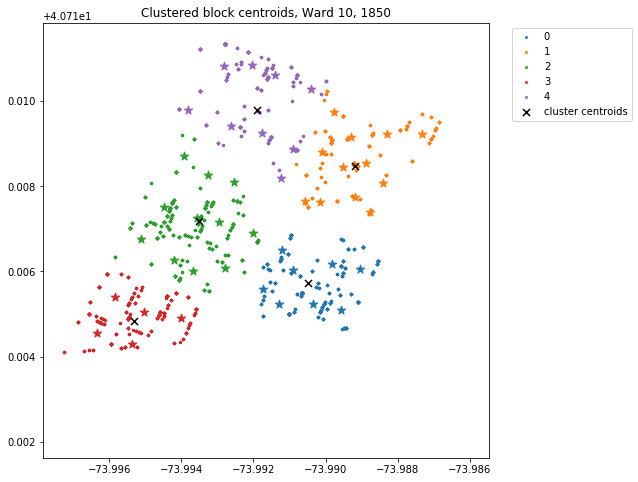

In [51]:
interpolate_enum = CentroidInterpolator(census_enumerators, 10, block_boost_enum, all_cols_enum, KMeans(5), block_centroids)
score, model = interpolate_enum.kmeans_best(5)
interpolate_enum.set_clustering_algo(model)
interpolate_enum.apply_clustering(algo_fit = True)
interpolate_enum.clustervis(kmeans = True)

In [52]:
train,test = interpolate_enum.stratified_train_test()
interpolate_enum.train_test_model(train, test)
print("Training score:",interpolate_enum.train_score)
print("Test score:", interpolate_enum.test_score)

Training score: 1.0
Test score: 0.6378286683630195


## census features + enumerator data

In [53]:
census_enumerators = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                                block_col =  block_col, x_col = x_col, y_col = y_col)
census_enumerators.no_seq()

all_cols_enum = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB",
                 "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", 
                 "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', 
                 "CENSUS_ENUMERATOR_NUM", "CENSUS_ENUMERATOR_DATE", "ANCESTRY_REF"]
block_boost_enum = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", 
                                                                  "CENSUS_PAGENUM", "CENSUS_SEXB", 
                                                                  "CENSUS_RACEB","CENSUS_DWELLING_SIZE",
                                                                  "CENSUS_SEQ_NUM", "CENSUS_LABFORCE", 
                                                                  "CENSUS_LINE", "CENSUS_MARST", 
                                                                  "CENSUS_NAMEFRST", "CENSUS_NAMELAST", 
                                                                  "CENSUS_OCCSTR", "CENSUS_IMPREL",
                                                                  'CENSUS_DWELLING_SEQ', "CENSUS_ENUMERATOR_NUM", 
                                                                  "CENSUS_ENUMERATOR_DATE", "ANCESTRY_REF"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

In [54]:
interpolate_enum = CentroidInterpolator(census_enumerators, 10, block_boost_enum, all_cols_enum, 
                                        KMeans(5), block_centroids)
score, model = interpolate_enum.kmeans_best(5)
interpolate_enum.set_clustering_algo(model)
interpolate_enum.apply_clustering(algo_fit = True)
# interpolate_enum.clustervis(kmeans = True)

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


In [55]:
train,test = interpolate_enum.stratified_train_test()
interpolate_enum.train_test_model(train, test)
print("Training score:",interpolate_enum.train_score)
print("Test score:", interpolate_enum.test_score)

Training score: 1.0
Test score: 0.504885993485342


## only enumerator sequence

In [57]:
census_enumerators_seq = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                                    block_col =  block_col, x_col = x_col, y_col = y_col)
census_enumerators_seq.apply_sequencing(enumerator = True)

all_cols_enum = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB",
                 "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", 
                 "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', 
                 "CENSUS_ENUMERATOR_NUM", "CENSUS_ENUMERATOR_DATE", "ANCESTRY_REF", "enum_seq"]
block_boost_enum = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM",
                                                                  "CENSUS_SEXB", "CENSUS_RACEB",
                                                                  "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", 
                                                                  "CENSUS_LABFORCE", "CENSUS_LINE", 
                                                                  "CENSUS_MARST", "CENSUS_NAMEFRST", 
                                                                  "CENSUS_NAMELAST", "CENSUS_OCCSTR", 
                                                                  "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', 
                                                                  "CENSUS_ENUMERATOR_NUM", "CENSUS_ENUMERATOR_DATE",
                                                                  "ANCESTRY_REF", "enum_seq"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


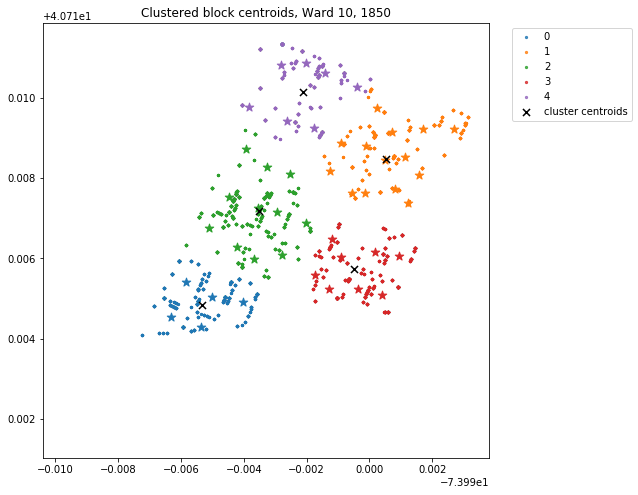

In [58]:
interpolate_enum = CentroidInterpolator(census_enumerators_seq, 10, block_boost_enum, all_cols_enum, 
                                        KMeans(5), block_centroids)
score, model = interpolate_enum.kmeans_best(5)
interpolate_enum.set_clustering_algo(model)
interpolate_enum.apply_clustering(algo_fit = True)
interpolate_enum.clustervis(kmeans = True)

In [59]:
train,test = interpolate_enum.stratified_train_test()
interpolate_enum.train_test_model(train, test)
print("Training score:",interpolate_enum.train_score)
print("Test score:", interpolate_enum.test_score)

Training score: 1.0
Test score: 0.4880573248407643


## dwelling + distance + enum

In [60]:
census_enumerators_seq = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                                    block_col =  block_col, x_col = x_col, y_col = y_col)
census_enumerators_seq.apply_sequencing(enumerator = True, distance = True, dwelling = True)

all_cols_enum = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB",
                 "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", 
                 "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",'CENSUS_DWELLING_SEQ', 
                 "sequence_order_enum", "sequence_id", "dwelling_seq_id", "CENSUS_ENUMERATOR_NUM", 
                 "CENSUS_ENUMERATOR_DATE", "ANCESTRY_REF", "enum_seq"]
block_boost_enum = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", 
                                                                  "CENSUS_PAGENUM", "CENSUS_SEXB", 
                                                                  "CENSUS_RACEB","CENSUS_DWELLING_SIZE",
                                                                  "CENSUS_SEQ_NUM", "CENSUS_LABFORCE", 
                                                                  "CENSUS_LINE", "CENSUS_MARST", 
                                                                  "CENSUS_NAMEFRST", "CENSUS_NAMELAST", 
                                                                  "CENSUS_OCCSTR", "CENSUS_IMPREL",
                                                                  'CENSUS_DWELLING_SEQ', "sequence_order_enum", 
                                                                  "sequence_id", "dwelling_seq_id", 
                                                                  "CENSUS_ENUMERATOR_NUM", "CENSUS_ENUMERATOR_DATE",
                                                                  "ANCESTRY_REF", "enum_seq"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


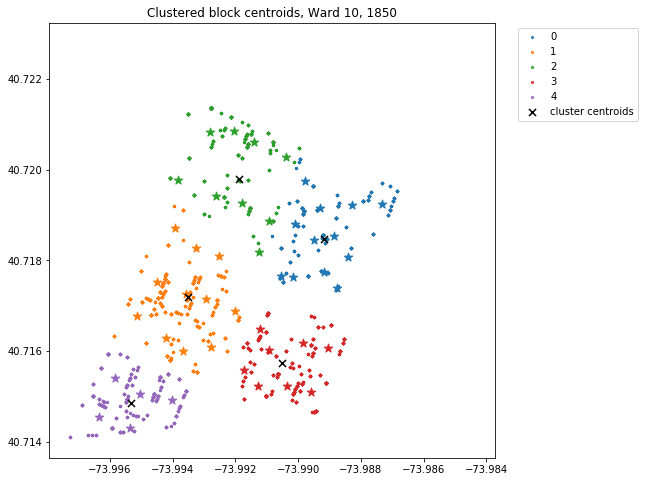

In [61]:
interpolate_enum = CentroidInterpolator(census_enumerators_seq, 10, block_boost_enum, all_cols_enum, KMeans(5), block_centroids)
score, model = interpolate_enum.kmeans_best(5)
interpolate_enum.set_clustering_algo(model)
interpolate_enum.apply_clustering(algo_fit = True)
interpolate_enum.clustervis(kmeans = True)

In [62]:
train,test = interpolate_enum.stratified_train_test()
interpolate_enum.train_test_model(train, test)
print("Training score:",interpolate_enum.train_score)
print("Test score:", interpolate_enum.test_score)

Training score: 1.0
Test score: 0.6182287188306105


## Enum_dist seq + dwelling + distance + fixed

In [63]:
census_enum_seq = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, fixed = True, distance = True)

all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL","sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", "enum_dist_order"]
block_boost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",  "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", "enum_dist_order"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

In [64]:
interpolate_sequences = CentroidInterpolator(census_enum_seq, 10, block_boost, all_cols, KMeans(5), 
                                             block_centroids)
score, model = interpolate_sequences.kmeans_best(5)
interpolate_sequences.set_clustering_algo(model)
interpolate_sequences.apply_clustering(algo_fit = True)
# interpolate_sequences.clustervis(kmeans = True)

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


In [65]:
train,test = interpolate_sequences.stratified_train_test()
interpolate_sequences.train_test_model(train, test)
print("Training score:",interpolate_sequences.train_score)
print("Test score:", interpolate_sequences.test_score)

Training score: 1.0
Test score: 0.6684684684684684


## Enum_dist only

In [66]:
census_enum_seq = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col = block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(enumerator_dist = True, d = 0.05)

all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", 
            "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", 
            "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL", 'CENSUS_DWELLING_SEQ', 
            "enum_dist_id", "enum_dist_order"]
block_boost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",  'CENSUS_DWELLING_SEQ', "enum_dist_id", "enum_dist_order"])),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, n_estimators = 50))])

In [67]:
interpolate_sequences = CentroidInterpolator(census_enum_seq, 10, block_boost, all_cols, KMeans(5), block_centroids)
score, model = interpolate_sequences.kmeans_best(5)
interpolate_sequences.set_clustering_algo(model)
interpolate_sequences.apply_clustering(algo_fit = True)
# interpolate_sequences.clustervis(kmeans = True)

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


In [68]:
train,test = interpolate_sequences.stratified_train_test()
interpolate_sequences.train_test_model(train, test)
print("Training score:",interpolate_sequences.train_score)
print("Test score:", interpolate_sequences.test_score)

Training score: 1.0
Test score: 0.6142735768903993
